In [2]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_excel(r"C:\Users\14088\OneDrive\Documents\Advanced Econometrics\Japan Project.xlsx")

Splitting Date into 2 columns for when they start their visit and end it.

In [5]:
df[['Start_Date', 'End_Date']] = df['Dates'].str.split(' ~ ', expand=True)

Function to calculate the length of the stay 

In [6]:
def calculate_days(start_date, end_date):
    start_date = datetime.strptime(start_date, "%Y.%m.%d")
    end_date = datetime.strptime(end_date, "%Y.%m.%d")
    difference = (end_date - start_date).days
    return difference

Loop to get the difference in days. Had some errors in the data, so the loop also catches those. Then I went to Excel and fixed the errors.

In [7]:
stay_length = []
for i in range(len(df)):
    try:
        stay_length.append(calculate_days(df["Start_Date"][i], df["End_Date"][i]))
    except ValueError as e:
        print(f"Error in row {i}: {e}")
        print(f"Start_Date: {df['Start_Date'][i]}, End_Date: {df['End_Date'][i]}")
    if stay_length[i] < 0:
        print(f"Start_Date: {df['Start_Date'][i]}, End_Date: {df['End_Date'][i]}")
        print(f"Error in row {i}")
df["Stay Length"] = stay_length


ILLING, Gerhard was listed as visiting until April 31st, which doesn't exist. According to the old news, he was there until April 30th.

MORENO DE BARREDA, Ines was listed as visiting from 2019.4.1-2019.1.9. I think it's until 2019.4.9.

AWAYA, Yu was listed as staying from 2018 to 2010. They probably meant 2019.

Histogram of all visits, across all years, with no cap on visit information:

(array([73., 21., 18.,  5.,  4.,  0.,  0.,  0.,  1.,  3.]),
 array([  1. ,  40.4,  79.8, 119.2, 158.6, 198. , 237.4, 276.8, 316.2,
        355.6, 395. ]),
 <BarContainer object of 10 artists>)

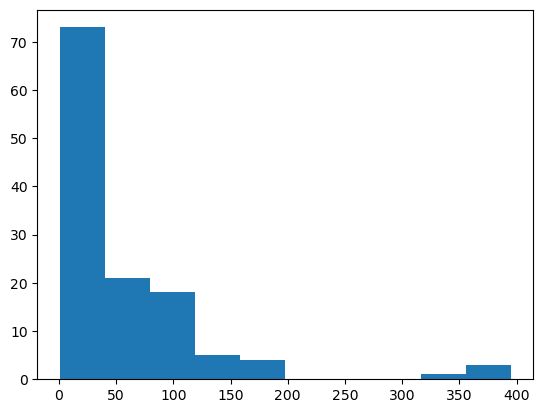

In [8]:
plt.hist(df["Stay Length"])

Now, censoring the data so visits longer than 35 days show up as 35, as that is the amount of time the visitors get paid for.
Of note, the website says the pay length can be extended to 65 days in special cases. 

<function matplotlib.pyplot.show(close=None, block=None)>

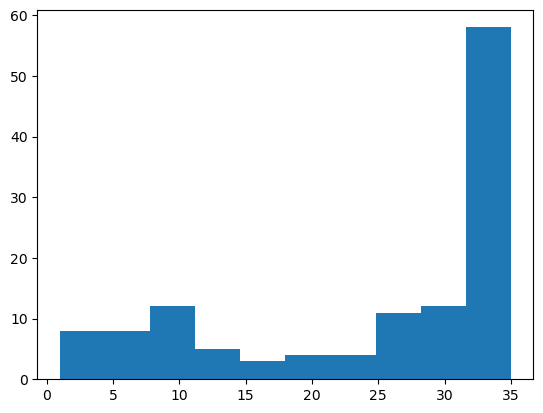

In [9]:
df['Censored_Stay_Length'] = np.clip(df['Stay Length'], a_min=None, a_max=35)
plt.hist(df["Censored_Stay_Length"])
plt.show

Now for some year by year analysis. Below creates a column that gives a year that each professor started their visit in. Then it creates a histogram for stay length for each year. 

Of note, the website says that the pay period can be extended to 65 days in certain cases, so the length of stay capped at 65 days is shown below. Honestly think this is the most useful graph, as it shows that most visitors hover around 30-35 days, which makes sense given that it is the pay cap. 

<function matplotlib.pyplot.show(close=None, block=None)>

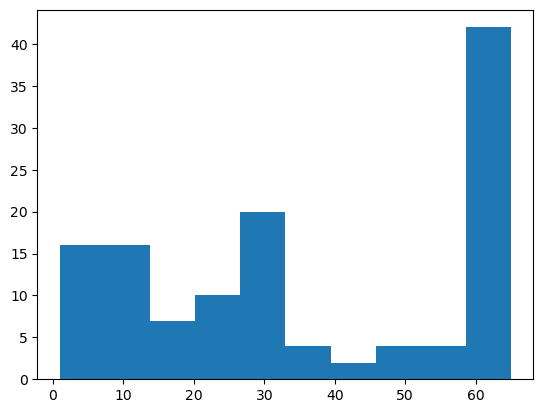

In [10]:
df['65censor'] = np.clip(df['Stay Length'],a_min=None, a_max=65)
plt.hist(df["65censor"])
plt.show

Below is code that loops through the years and creates histograms for the length of stay for each year. 

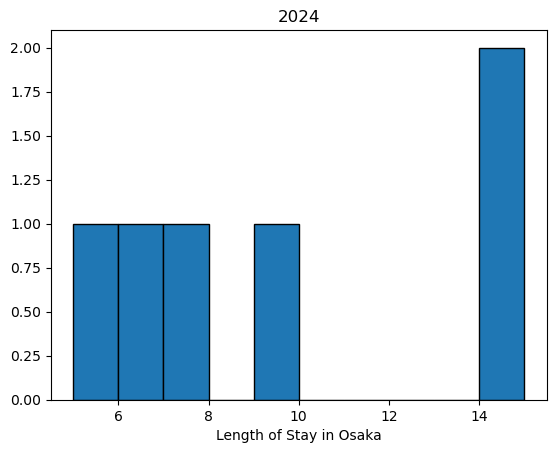

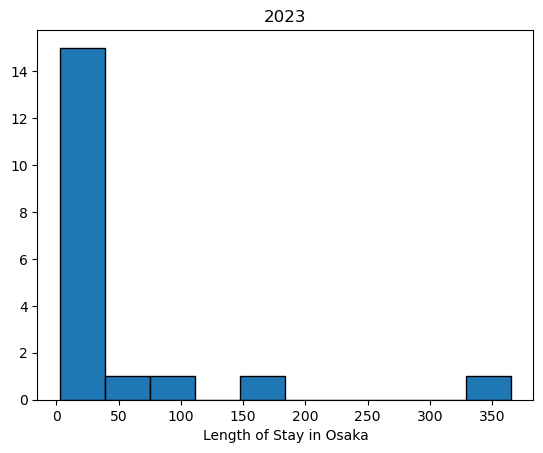

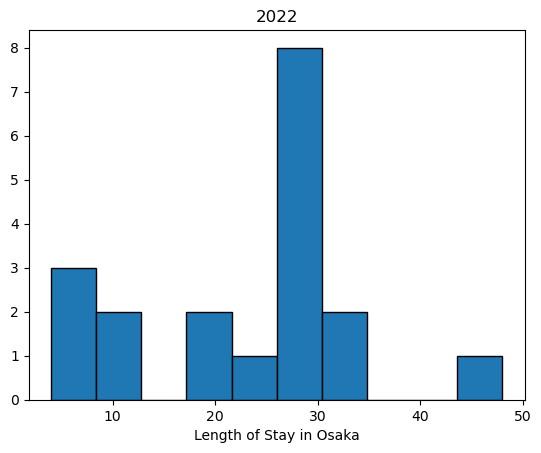

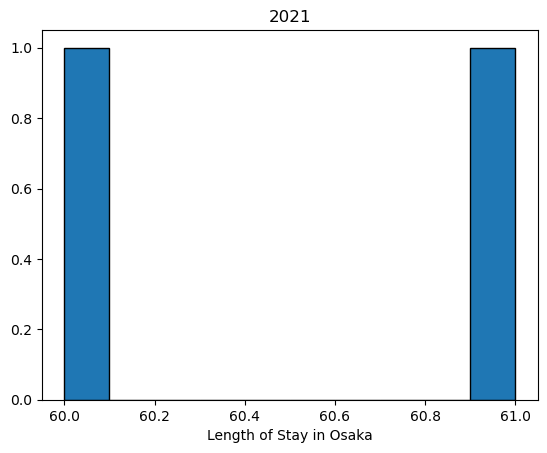

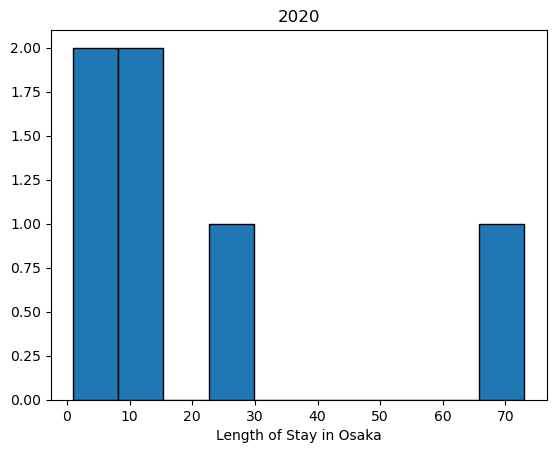

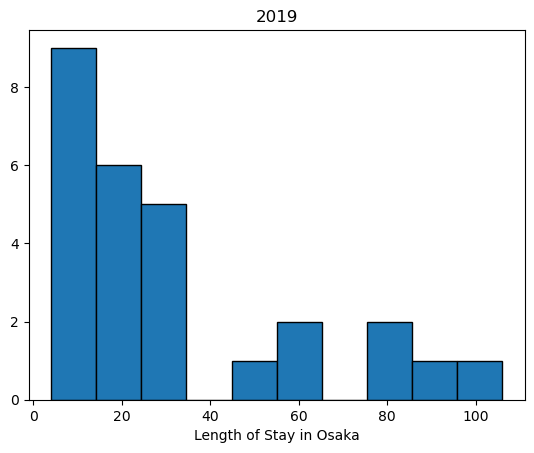

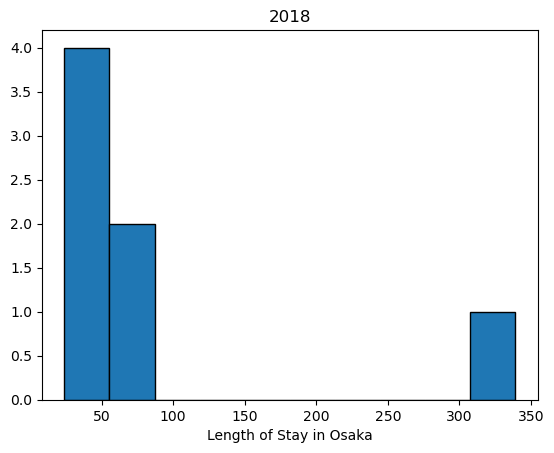

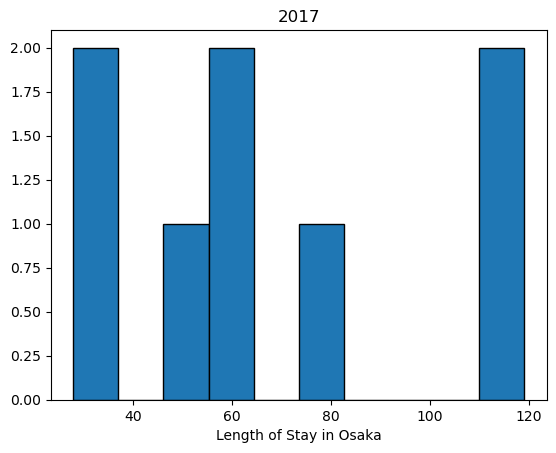

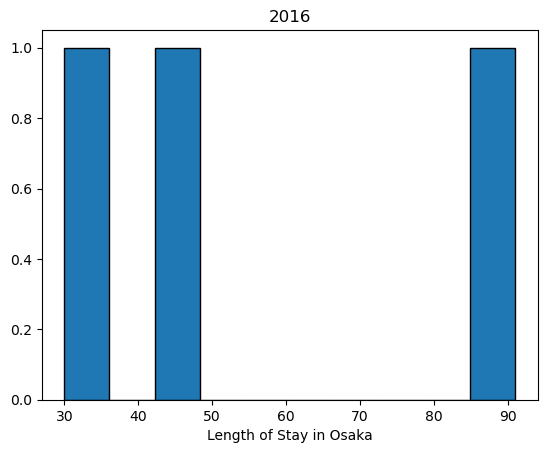

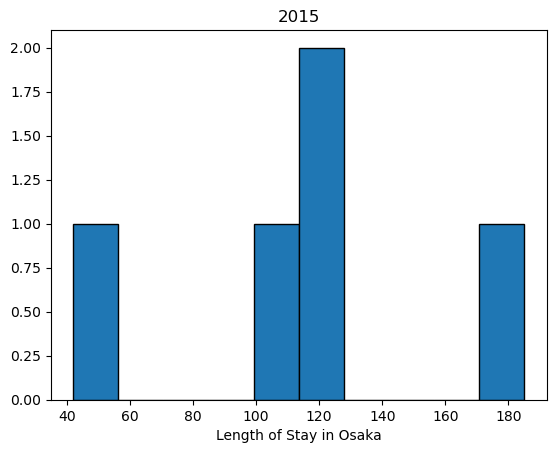

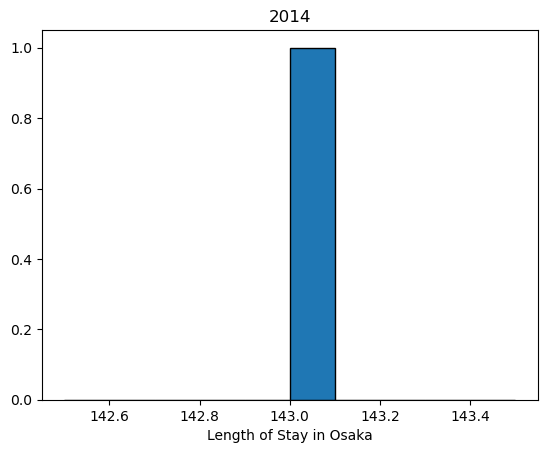

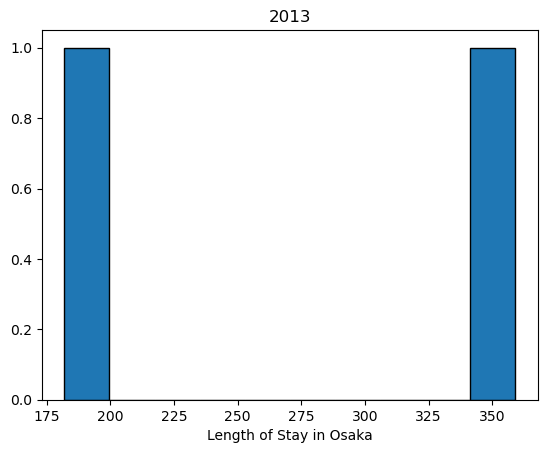

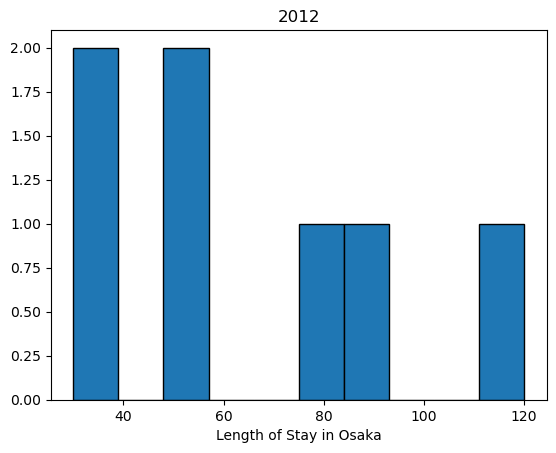

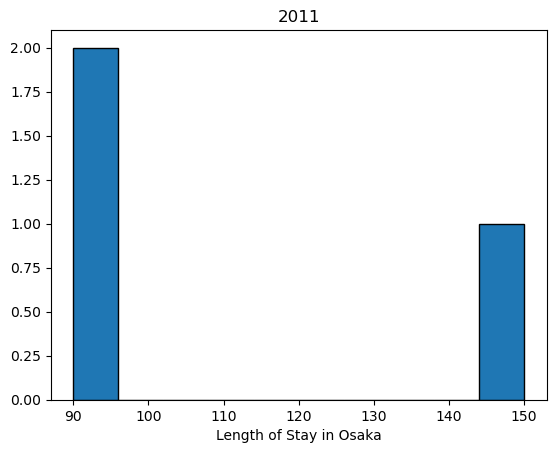

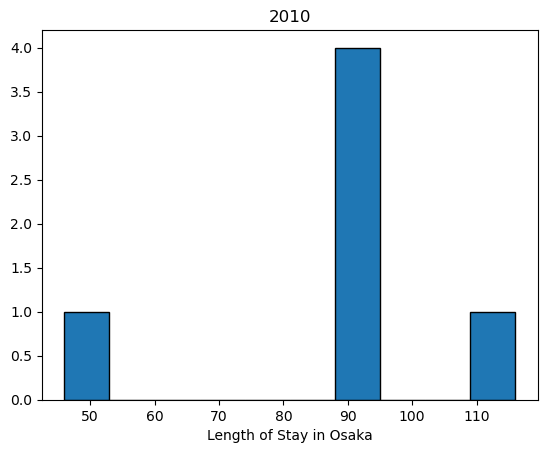

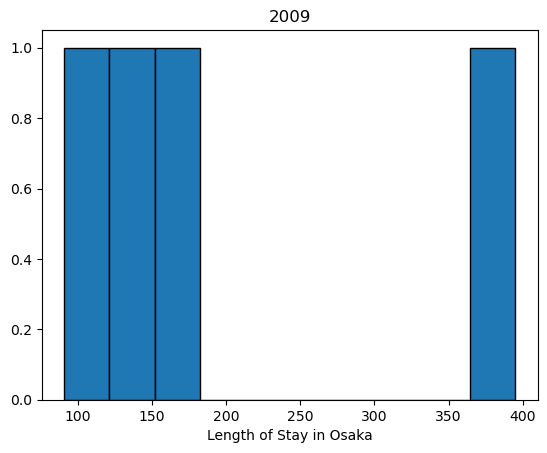

In [11]:
# The year each professor visited is when they arrived in Osaka. Notable for professors who stay from December to January, for example.
df['year'] = df['Start_Date'].str.extract(r'(\d{4})')
df['year'] = df['year'].astype(str)

# Iterate over 2009-2024 years and create histograms
for year in df['year'].unique():
    plt.figure()  
    plt.hist(df[df['year'] == year]['Stay Length'], bins=10, edgecolor='black')
    plt.title(f'{year}')
    plt.xlabel('Length of Stay in Osaka')
    plt.show()
    
# When looking at the histograms, the scale is different for all of them. 

Below are the quartiles, the median, and the mean across all years.

In [13]:
p10 = np.percentile(df['Stay Length'], 10)
q1 = np.percentile(df['Stay Length'], 25)
q2 = np.percentile(df['Stay Length'], 50)  # Median
q3 = np.percentile(df['Stay Length'], 75)
p90 = np.percentile(df['Stay Length'], 90)
average_length = df['Stay Length'].mean()

summary_df = pd.DataFrame({
    'Statistic': ['p10', 'Q1', 'Q2 (Median)', 'Q3', 'p90', 'Average Length'],
    'Value': [p10, q1, q2, q3, p90, average_length]
})

print(summary_df)

        Statistic    Value
0             p10    7.000
1              Q1   13.000
2     Q2 (Median)   30.000
3              Q3   79.000
4             p90  119.600
5  Average Length   57.032


Now year by year percentiles, median, and mean

In [14]:
def calculate_statistics(data):
    p10 = np.percentile(data, 10)
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)  # Median
    q3 = np.percentile(data, 75)
    p90 = np.percentile(data, 90)
    average_length = np.mean(data)

    return pd.Series({
        'p10': p10,
        'Q1': q1,
        'Q2 (Median)': q2,
        'Q3': q3,
        'p90': p90,
        'Average Length': average_length
    })

summary_by_year = df.groupby('year')['Stay Length'].apply(calculate_statistics).reset_index()

print(summary_by_year)

    year         level_1  Stay Length
0   2009             p10   100.300000
1   2009              Q1   114.250000
2   2009     Q2 (Median)   146.500000
3   2009              Q3   227.000000
4   2009             p90   327.800000
..   ...             ...          ...
91  2024              Q1     6.250000
92  2024     Q2 (Median)     8.000000
93  2024              Q3    12.750000
94  2024             p90    14.500000
95  2024  Average Length     9.333333

[96 rows x 3 columns]


Indexing by name as some professors visit multiple times. Does need some work, as I only want to not double count professors who left and came back in the same year, i.e ones who are entered right above/below other in the Excel file Then calculating the number of visitors per year, the total days of visits per year, average length each professor visited. 

In [15]:
unique_visitors = df.groupby(['year', 'Name']).size().reset_index(name='Num_Visits')
total_visitors_per_year = unique_visitors.groupby('year')['Num_Visits'].count().reset_index(name='Total_Visitors')
total_days_per_year = df.groupby('year')['Stay Length'].sum().reset_index(name='Total_Days')

result_df = pd.DataFrame(total_visitors_per_year)
result_df = pd.merge(result_df, total_days_per_year, on='year')
result_df["Average_days"]=result_df["Total_Days"]/result_df["Total_Visitors"]
print(result_df)

    year  Total_Visitors  Total_Days  Average_days
0   2009               4         779    194.750000
1   2010               6         525     87.500000
2   2011               3         331    110.333333
3   2012               7         456     65.142857
4   2013               2         541    270.500000
5   2014               1         143    143.000000
6   2015               5         565    113.000000
7   2016               3         165     55.000000
8   2017               8         548     68.500000
9   2018               7         594     84.857143
10  2019              23         847     36.826087
11  2020               6         133     22.166667
12  2021               2         121     60.500000
13  2022              19         437     23.000000
14  2023              19         888     46.736842
15  2024               6          56      9.333333


In [16]:
np.mean((result_df['Total_Visitors']))

7.5625

Below is the same calculation as above, but now the stay length is capped at 35. 

In [17]:
df['stay_length_capped'] = df['Stay Length'].clip(upper=35)

total_visitors_per_year = df.groupby(['year', 'Name']).size().reset_index(name='num_visits')

total_visitors_per_year['num_visits'] = total_visitors_per_year['num_visits'].clip(upper=35)

total_days_per_year = df.groupby('year')['stay_length_capped'].sum().reset_index(name='total_days')

capped_df = pd.merge(total_visitors_per_year.groupby('year')['num_visits'].count().reset_index(name='total_visitors'), total_days_per_year, on='year')
capped_df["average_days"] = capped_df["total_days"]/capped_df["total_visitors"]
print(capped_df)

    year  total_visitors  total_days  average_days
0   2009               4         140     35.000000
1   2010               6         210     35.000000
2   2011               3         105     35.000000
3   2012               7         239     34.142857
4   2013               2          70     35.000000
5   2014               1          35     35.000000
6   2015               5         175     35.000000
7   2016               3         100     33.333333
8   2017               8         271     33.875000
9   2018               7         216     30.857143
10  2019              23         579     25.173913
11  2020               6          95     15.833333
12  2021               2          70     35.000000
13  2022              19         424     22.315789
14  2023              19         352     18.526316
15  2024               6          56      9.333333


In [18]:
print(np.mean((capped_df['total_days'])))


196.0625


In [19]:
result_df["average_capped_days"] = capped_df["average_days"]
print(result_df)

    year  Total_Visitors  Total_Days  Average_days  average_capped_days
0   2009               4         779    194.750000            35.000000
1   2010               6         525     87.500000            35.000000
2   2011               3         331    110.333333            35.000000
3   2012               7         456     65.142857            34.142857
4   2013               2         541    270.500000            35.000000
5   2014               1         143    143.000000            35.000000
6   2015               5         565    113.000000            35.000000
7   2016               3         165     55.000000            33.333333
8   2017               8         548     68.500000            33.875000
9   2018               7         594     84.857143            30.857143
10  2019              23         847     36.826087            25.173913
11  2020               6         133     22.166667            15.833333
12  2021               2         121     60.500000            35

In [20]:
sum(result_df["average_capped_days"])

468.3910183066361